In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import PIL , requests
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import pyprind

2021-12-19 01:30:33.866301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2021-12-19 01:30:49.334501: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-19 01:30:49.368446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-19 01:30:49.411712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 01:30:49.412250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 104.43GiB/

In [3]:
base_path = r"/home/bl4ckc4t/Documents/Datasets/Pneumonia/"

paths = [base_path + 'train',
         base_path + 'test',
         base_path + 'val']

In [4]:
def get_data(path):
    
    X = []
    
    y = []

    data = pathlib.Path(path)
    
    data = list(data.glob('*/*.jpeg'))
    
    pbar = pyprind.ProgBar(len(data))
    
    for i in data:
    
        image = np.asarray(PIL.Image.open(str(i)).resize([150,150]))
        
        X.append(image)
        
        pneu = re.search('PNEUMONIA',str(i))
        
        norm = re.search('NORMAL',str(i))
        
        if pneu != None:
        
            if pneu.group() == 'PNEUMONIA':
                
                y.append(1)
            
        elif norm != None:
            
            if norm.group() == 'NORMAL':
                
                y.append(0)
                
        pbar.update()
    
    return X , y 


In [5]:
train_X , train_y = get_data(paths[0])

test_X , test_y = get_data(paths[1])

val_X , val_y = get_data(paths[2])

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:52
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11
0% [################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [6]:
#XX = np.array(train_X,dtype = 'float64')

train_X[0].shape

(150, 150)

In [7]:
print(train_X[-1] , train_y[-1])

[[164 161 157 ...  82 107 181]
 [ 61  58  57 ...  85 135 192]
 [ 44  43  42 ... 115 157 188]
 ...
 [ 19  19  19 ...   3   5   7]
 [ 18  18  18 ...   3   5   7]
 [ 19  20  19 ...   3   6   7]] 0


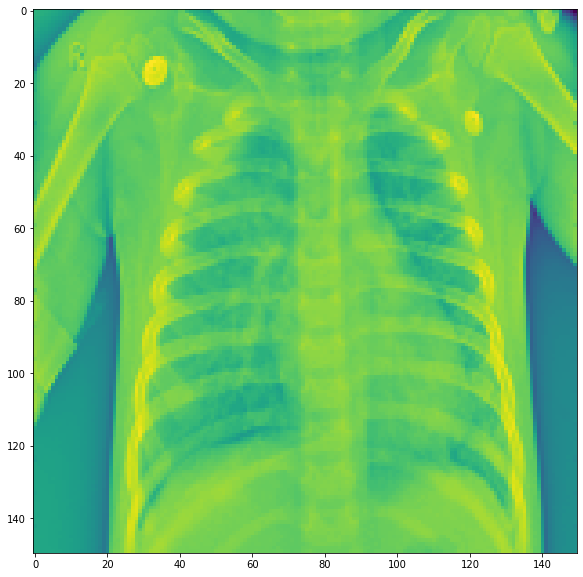

In [8]:
fig = plt.figure(figsize = (10,10))

plt.imshow(train_X[0])

plt.show()

In [9]:
l = []

for path in paths:
    
    data = pathlib.Path(path)

    l.append(len(list(data.glob('*/*.jpeg'))))

data_size = pd.DataFrame(data={'Values':l,'Sets':['training','testing','validation']})
data_size

,Values,Sets
0,5216,training
1,624,testing
2,16,validation


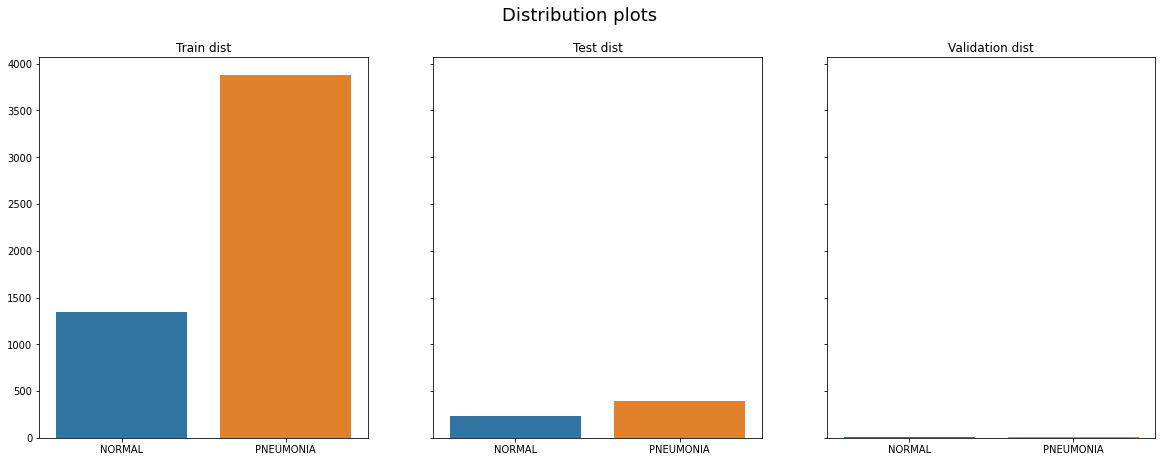

In [10]:
fig , ax = plt.subplots(nrows = 1,
                        ncols = 3,
                        figsize = (20,7),
                        sharey = True)

fig.suptitle('Distribution plots',fontsize = 18)

sets = ['Train','Test','Validation']

for k in range(3):
    
    dat = pathlib.Path(paths[k])
    
    n_norm = len(list(dat.glob('NORMAL/*')))
    
    n_pneu = len(list(dat.glob('PNEUMONIA/*')))
    
    sns.barplot(ax = ax[k],
                y = [n_norm,n_pneu],
                x = ['NORMAL','PNEUMONIA'])
    
    ax[k].set_title(f'{sets[k]} dist')
    
plt.show()

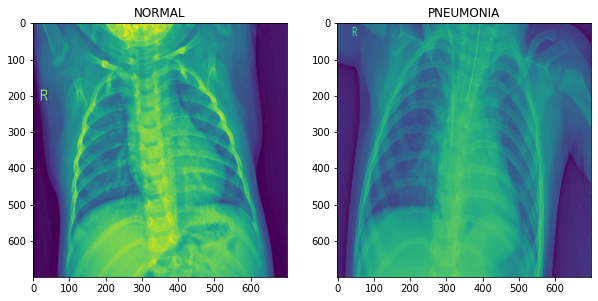

In [11]:
training = pathlib.Path(paths[0])

norm = list(training.glob('NORMAL/*'))
image_n = np.asarray(PIL.Image.open(str(norm[10])).resize([700,700]))

pneu = list(training.glob('PNEUMONIA/*'))
image_p = np.asarray(PIL.Image.open(str(pneu[10])).resize([700,700]))

plt.figure(figsize=(10,10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(image_n)
ax1.set_title('NORMAL')
ax2.imshow(image_p)
ax2.set_title('PNEUMONIA')
plt.show()

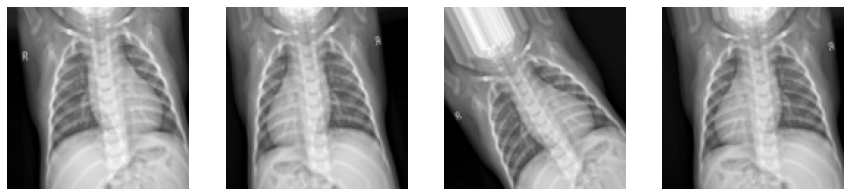

In [12]:
augmented_image = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 30,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = False,
                                    fill_mode = 'nearest')

img_test = np.asarray(PIL.Image.open(str(norm[10])).resize([124,124]))

img_test = img_test.reshape(1,124,124,1)

fig , ax = plt.subplots(nrows = 1,ncols = 4,figsize = (15,10))

k = 0

for batch in augmented_image.flow(img_test, batch_size = 1):

    ax[k].imshow(batch[0].reshape(124,124),cmap='gray')

    ax[k].axis('off')

    k += 1 

    if k == 4:
        
        break

In [13]:
XX = np.array(train_X,dtype='object')

ValueError: could not broadcast input array from shape (150,150,3) into shape (150,150)

In [14]:
IMG_WIDTH ,IMG_HEIGHT = 124, 124

BATCH_SIZE = 32

classes = ['NORMAL','PNEUMONIA']

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               vertical_flip = False,
                               fill_mode = 'nearest')


test_gen = ImageDataGenerator(rescale = 1./255 )


validation_gen = ImageDataGenerator(rescale = 1./255 )


train_gen.fit(train_X)

ValueError: could not broadcast input array from shape (150,150,3) into shape (150,150)

In [ ]:
train_set = train_gen.flow_from_directory(directory = paths[0],
                                          target_size = (IMG_WIDTH ,IMG_HEIGHT),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary',
                                          classes = classes)


test_set = test_gen.flow_from_directory(directory = paths[1],
                                          target_size = (IMG_WIDTH ,IMG_HEIGHT),
                                          class_mode = 'binary',
                                          classes = classes)


validation_set = validation_gen.flow_from_directory(directory = paths[2],
                                          target_size = (IMG_WIDTH ,IMG_HEIGHT),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary',
                                          classes = classes)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models
from tensorflow.keras.layers import Dense ,Dropout ,Flatten ,Conv2D , MaxPooling2D



model = models.Sequential()


model.add(Conv2D(input_shape = (IMG_WIDTH ,IMG_HEIGHT,3),
                 filters = 64,
                 kernel_size = (3,3),
                 padding = 'same',
                 strides = 1))


model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'same',
                 strides = 2))


model.add(MaxPooling2D(pool_size = (3,3),
                      strides = 1,
                      padding = 'same'))

model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'valid',
                 strides = 2))


model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'same',
                 strides = 2))


model.add(MaxPooling2D(pool_size = (3,3),
                      strides = 2,
                      padding = 'valid'))


model.add(Flatten())

model.add(Dense(units = 64, activation = 'relu'))

model.add(Dropout( rate = 0.3))

model.add(Dense(units = 1 ,activation = 'sigmoid',kernel_regularizer = l2(0.001)))

model.summary()

In [ ]:
model.compile( loss = 'binary_crossentropy',
               optimizer = 'adam' , 
               metrics = ['Recall','accuracy'])

In [ ]:
from tensorflow.keras import callbacks

learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience = 1,
                                                            verbose=1,
                                                            factor=0.3,
                                                            min_lr=0.000001)

early_stop = callbacks.EarlyStopping(monitor='val_accuracy', 
                                     patience = 3 ,
                                     restore_best_weights = True)

In [ ]:
EPOCHS = 20

history = model.fit(x = train_set,
                    validation_data = validation_set,
                    epochs = EPOCHS,
                    callbacks = [learning_rate_reduction, early_stop])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img_path = r'/home/bl4ckc4t/Documents/Datasets/Pneumonia/chest_xray/test/PNEUMONIA/person1614_virus_2800.jpeg'

In [ ]:
from tensorflow.keras.preprocessing import image

test = pathlib.Path(paths[1])

norm = list(test.glob('NORMAL/*'))

pneu = list(test.glob('PNEUMONIA/*'))

classes = ['NORMAL','PNEUMONIA']

img = image.load_img(norm[1],target_size=(IMG_WIDTH, IMG_HEIGHT))

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

y_hat = int(model.predict(img_batch))

print(img_array.shape)

print(classes[y_hat])

In [ ]:
y_hat = model.predict(img_batch)
y_hat

In [ ]:

def get_acc_class(class_name , name):
    
    c = 0

    for k in range(len(class_name)):
        
        treshold = 0.5

        img = image.load_img(class_name[k],target_size=(IMG_WIDTH, IMG_HEIGHT))

        img_array = image.img_to_array(img)

        img_batch = np.expand_dims(img_array, axis=0)

        y_hat = model.predict(img_batch)

        if name == 'normal':
            
            if  y_hat <= treshold:

                c += 1
                
        elif name == 'pneumonia':
            
            if  y_hat > treshold:

                c += 1
        else:
            break
            
    return c ,(c / len(class_name))*100

correct_norm , acc_norm  = get_acc_class(norm,'normal')
correct_pneu , acc_pneu  = get_acc_class(pneu,'pneumonia')

print(correct_norm , acc_norm )    
print(correct_pneu , acc_pneu )

In [ ]:
print(f'Final Accuracy : {( (correct_norm + correct_pneu) / (len(norm) + len(pneu)))*100 } %')

In [ ]:
model.save(r'/home/bl4ckc4t/Documents/Models/Model(87%acc).h5')